In [1]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path

# 0. Data loading 

We will use the cleaned datsets from the `generateDefinitiveDataset.ipynb` notebook that are: 
- **Consumption data**: Split parquet files in `clean/split_consum_bcn/`
- **Leak incidents data**: Single parquet file `clean/fuites_clean_bcn.parquet`
- **Weather data**: `clean/weather_clean.parquet`
- **Socioeconomic data**: `clean/socio_clean.parquet`

In [2]:
# Weather
df_weather = pd.read_parquet("clean/weather_clean.parquet")
# Socioeconomic
df_socio = pd.read_parquet("clean/socio_clean.parquet")
# Leaks
df_fuites = pd.read_parquet("clean/fuites_clean_bcn.parquet")
# Consumption split files
consum_files = sorted(glob.glob("clean/split_consum_bcn/consum_clean_bcn_part_*.parquet"))
df_consum_list = [pd.read_parquet(fp) for fp in consum_files]
df_consum = pd.concat(df_consum_list, ignore_index=True)

print("\nLoaded datasets:")
print(f"  Weather: {df_weather.shape[0]:,} rows")
print(f"  Socioeconomic: {df_socio.shape[0]:,} rows")
print(f"  Leaks: {df_fuites.shape[0]:,} rows")
print(f"  Consumption: {df_consum.shape[0]:,} rows from {len(consum_files)} split files")


Loaded datasets:
  Weather: 129,104 rows
  Socioeconomic: 1,068 rows
  Leaks: 1,359 rows
  Consumption: 10,068,280 rows from 18 split files


# 1. Data Validation

In [3]:
print("="*120)
print("DATA VALIDATION REPORT")
print("="*120)

# ==========================================================================================
# 1. VALIDATE COLUMN TYPES + NULLS
# ==========================================================================================

def validate_dataset(df, name):
    print("\n" + "-"*80)
    print(f"VALIDATION: {name}")
    print("-"*80)
    
    # Check column types
    print("\nColumn types:")
    print(df.dtypes)
    
    # Missing values
    print("\nMissing values (top 10):")
    print(df.isna().sum().sort_values(ascending=False).head(10))
    
    # Duplicate rows
    dup_count = df.duplicated().sum()
    print(f"\nDuplicate rows: {dup_count:,}")
    
    # Memory usage
    print(f"Memory usage: {df.memory_usage(deep=True).sum()/1024/1024:.2f} MB")

validate_dataset(df_consum, "Consumption")
validate_dataset(df_fuites, "Leaks")
validate_dataset(df_weather, "Weather")
validate_dataset(df_socio, "Socioeconomic")

# ==========================================================================================
# 2. VALIDATE TEMPORAL COVERAGE
# ==========================================================================================

def validate_dates(df, date_col, name):
    print("\n" + "-"*80)
    print(f"TEMPORAL VALIDATION: {name}")
    print("-"*80)

    if date_col not in df.columns:
        print(f"⚠ Date column '{date_col}' missing!")
        return
    
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    n_null = df[date_col].isna().sum()

    print(f"Null dates: {n_null:,}")
    print(f"Earliest date: {df[date_col].min()}")
    print(f"Latest date: {df[date_col].max()}")
    print(f"Unique dates: {df[date_col].nunique():,}")

validate_dates(df_consum, "FECHA", "Consumption")
validate_dates(df_fuites, "CREATED_MENSAJE", "Leaks")
validate_dates(df_weather, "DATA_LECTURA", "Weather")

# ==========================================================================================
# 3. VALIDATE SPATIAL COVERAGE (SECCIO_CENSAL)
# ==========================================================================================

def validate_spatial(df, name):
    print("\n" + "-"*80)
    print(f"SPATIAL VALIDATION: {name}")
    print("-"*80)

    if "SECCIO_CENSAL" not in df.columns:
        print("⚠ Missing SECCIO_CENSAL column")
        return

    unique_sections = df["SECCIO_CENSAL"].nunique()
    print(f"Unique SECCIO_CENSAL count: {unique_sections:,}")

    # Check formatting: all codes should be 11 digits starting with 080193
    mask_valid = df["SECCIO_CENSAL"].astype(str).str.match(r"^080193\d{5}$")
    invalid = df.loc[~mask_valid, "SECCIO_CENSAL"]

    print(f"Invalid census codes: {len(invalid)}")
    if len(invalid) > 0:
        print(invalid.head())

validate_spatial(df_consum, "Consumption")
validate_spatial(df_fuites, "Leaks")
validate_spatial(df_socio, "Socioeconomic")

# ==========================================================================================
# 4. CROSS-DATASET ALIGNMENT CHECKS
# ==========================================================================================

print("\n" + "="*120)
print("CROSS-DATASET ALIGNMENT")
print("="*120)

# Unique census sections
sec_consum = set(df_consum["SECCIO_CENSAL"].unique())
sec_fuites = set(df_fuites["SECCIO_CENSAL"].unique())
sec_socio  = set(df_socio["SECCIO_CENSAL"].unique())

print(f"\nTotal census sections:")
print(f"  Socioeconomic: {len(sec_socio):,}")
print(f"  Consumption:  {len(sec_consum):,}")
print(f"  Leaks:        {len(sec_fuites):,}")

# Intersections
print("\nIntersections:")
print(f"  Socio ∩ Consum: {len(sec_socio & sec_consum):,}")
print(f"  Socio ∩ Fuites: {len(sec_socio & sec_fuites):,}")
print(f"  Consum ∩ Fuites: {len(sec_consum & sec_fuites):,}")
print(f"  All three: {len(sec_socio & sec_consum & sec_fuites):,}")

# ==========================================================================================
# 5. CHECK FOR DUPLICATE METERS IN CONSUMPTION
# ==========================================================================================

print("\n" + "="*120)
print("METER VALIDATION (Consumption)")
print("="*120)

# A meter should not have overlapping dates
df_consum["FECHA"] = pd.to_datetime(df_consum["FECHA"], errors="coerce")
dup_meter_date = df_consum.duplicated(subset=["POLIZA_SUMINISTRO", "FECHA"]).sum()

print(f"Duplicate (POLIZA_SUMINISTRO + FECHA) rows: {dup_meter_date:,}")

# ==========================================================================================
# 6. VALUE VALIDATION — UNIT-AWARE WEATHER CHECKS
# ==========================================================================================

print("\n" + "="*120)
print("VALUE VALIDATION (Unit-aware)")
print("="*120)

print("\nUnique UNITAT values in df_weather:")
print(df_weather["UNITAT"].unique())

rules = {
    "°C": (-40, 50),        # realistic temperature range for Barcelona
    "%": (0, 100),          # valid humidity range
    "hPa": (900, 1100),     # typical pressure range
    "mm": (0, 500),         # rainfall per day upper cap (rare but possible)
    "MJ/m2": (0, 40),       # solar radiation
    "m/s": (0, 40),         # wind speed
    "°": (0, 360)           # direction angles
}

invalid_summary = []

for unit, (lo, hi) in rules.items():
    mask = df_weather["UNITAT"] == unit
    subset = df_weather[mask]

    invalid = subset[(subset["VALOR_NUM"] < lo) | (subset["VALOR_NUM"] > hi)]
    invalid_summary.append((unit, len(invalid)))

    print(f"\nUNIT: {unit}")
    print(f"  Allowed range: {lo} to {hi}")
    print(f"  Rows checked: {len(subset):,}")
    print(f"  Invalid values: {len(invalid):,}")

print("\nSummary of invalid per unit:")
for u, cnt in invalid_summary:
    print(f"  {u}: {cnt} invalid values")


print("\nDATA VALIDATION COMPLETED.")


DATA VALIDATION REPORT

--------------------------------------------------------------------------------
VALIDATION: Consumption
--------------------------------------------------------------------------------

Column types:
POLIZA_SUMINISTRO            object
FECHA                datetime64[ns]
CONSUMO_REAL                  int64
SECCIO_CENSAL                object
US_AIGUA_GEST                object
DATA_INST_COMP       datetime64[ns]
dtype: object

Missing values (top 10):
POLIZA_SUMINISTRO    0
FECHA                0
CONSUMO_REAL         0
SECCIO_CENSAL        0
US_AIGUA_GEST        0
DATA_INST_COMP       0
dtype: int64

Duplicate rows: 0
Memory usage: 2141.21 MB

--------------------------------------------------------------------------------
VALIDATION: Leaks
--------------------------------------------------------------------------------

Column types:
POLISSA_SUBM       object
CREATED_MENSAJE    object
CODIGO_MENSAJE     object
US_AIGUA_SUBM      object
SECCIO_CENSAL      objec

In order to finish the data validation and fix the problems encountered we will: 
- Drop the 103 duplicate rows of the **consum dataset** in order to have only unique entries. Each pair of duplicates is in the same chunk so we will clean all the chunks in order to have only unique values. 
- Drop the 197 missing entries for Estat in the **weather dataset** since we only want the representative values, no need to keep the non-representative, and since the entire column will have the same value, we can drop the entire column once the missing values have been removed. 


In [6]:
# Folder with split consumption files
consum_dir = Path("clean/split_consum_bcn")
consum_files = sorted(glob.glob(str(consum_dir / "consum_clean_bcn_part_*.parquet")))

print(f"Found {len(consum_files)} split consum files")
print("-" * 80)

key_cols = ['POLIZA_SUMINISTRO', 'FECHA']

total_before = 0
total_after = 0
total_dups_removed = 0

# -------------------------------------------------------------------
# 1. Deduplicate *within each chunk* and overwrite file
# -------------------------------------------------------------------
for i, fp in enumerate(consum_files, start=1):
    file_name = Path(fp).name
    print(f"Processing chunk {i}/{len(consum_files)}: {file_name}")

    df_chunk = pd.read_parquet(fp)
    total_before += len(df_chunk)

    # Ensure FECHA is datetime
    df_chunk['FECHA'] = pd.to_datetime(df_chunk['FECHA'], errors='coerce')

    # Detect duplicate rows within the chunk
    dup_mask = df_chunk.duplicated(subset=key_cols, keep='first')
    n_dups = dup_mask.sum()
    total_dups_removed += n_dups

    if n_dups > 0:
        print(f"  - Found {n_dups} duplicates inside chunk")

    # Drop duplicates (keep first)
    df_clean = df_chunk.drop_duplicates(subset=key_cols, keep='first')
    total_after += len(df_clean)

    # Overwrite chunk file IN PLACE
    df_clean.to_parquet(fp, index=False)
    print(f"  - Saved cleaned chunk ({len(df_clean)} rows)")

print("-" * 80)
print(f"Total rows before cleaning: {total_before:,}")
print(f"Total rows after cleaning:  {total_after:,}")
print(f"Total duplicates removed:   {total_dups_removed:,}")

# -------------------------------------------------------------------
# 2. Global duplicate check (across chunks)
# -------------------------------------------------------------------
print("\nChecking for duplicates across chunks...")

df_all = []
for fp in consum_files:
    df_chunk = pd.read_parquet(fp)
    df_all.append(df_chunk)

df_all = pd.concat(df_all, ignore_index=True)

global_dups = df_all.duplicated(subset=key_cols, keep=False).sum()

if global_dups == 0:
    print("✓ No global duplicates remain across chunks!")
else:
    print(f"⚠ Found {global_dups} duplicates across chunks (should be 0).")

# -------------------------------------------------------------------
# 3. Drop missing Estat in weather data + drop Estat column
# -------------------------------------------------------------------
# Consumption split files
consum_files = sorted(glob.glob("clean/split_consum_bcn/consum_clean_bcn_part_*.parquet"))
df_consum_list = [pd.read_parquet(fp) for fp in consum_files]
df_consum = pd.concat(df_consum_list, ignore_index=True)


# 1. Drop rows where Estat is NaN (they are invalid / not useful)
df_weather = df_weather[df_weather['Estat'].notna()].copy()

# 2. Drop Estat column entirely because it holds no useful information
df_weather = df_weather.drop(columns=['Estat'])

print("After cleaning:", df_weather.shape)
print("Columns now:", df_weather.columns)

# Save cleaned version (overwrite or create a new name)
output = Path("clean/weather_clean.parquet")
df_weather.to_parquet(output, index=False)

print("\n✓ Cleaned weather data saved to:", output)

Found 18 split consum files
--------------------------------------------------------------------------------
Processing chunk 1/18: consum_clean_bcn_part_001.parquet
  - Saved cleaned chunk (24725 rows)
Processing chunk 2/18: consum_clean_bcn_part_002.parquet
  - Saved cleaned chunk (142432 rows)
Processing chunk 3/18: consum_clean_bcn_part_003.parquet
  - Saved cleaned chunk (127911 rows)
Processing chunk 4/18: consum_clean_bcn_part_004.parquet
  - Saved cleaned chunk (68311 rows)
Processing chunk 5/18: consum_clean_bcn_part_005.parquet
  - Saved cleaned chunk (391381 rows)
Processing chunk 6/18: consum_clean_bcn_part_006.parquet
  - Saved cleaned chunk (999987 rows)
Processing chunk 7/18: consum_clean_bcn_part_007.parquet
  - Saved cleaned chunk (903217 rows)
Processing chunk 8/18: consum_clean_bcn_part_008.parquet
  - Saved cleaned chunk (776714 rows)
Processing chunk 9/18: consum_clean_bcn_part_009.parquet
  - Saved cleaned chunk (735314 rows)
Processing chunk 10/18: consum_clean_b

KeyError: 'Estat'

In [7]:
print("="*120)
print("PART 2 — EXTENDED VALIDATION")
print("="*120)

# ============================================================
# A) TEMPORAL OVERLAP + MISSING DAYS CHECK
# ============================================================

def check_missing_days(df, date_col, name):
    print("\n" + "-"*80)
    print(f"MISSING-DAY VALIDATION: {name}")
    print("-"*80)

    df = df.copy()
    dates = df[date_col].dropna().sort_values()

    if dates.empty:
        print("⚠ No valid dates found.")
        return

    full_range = pd.date_range(start=dates.min(), end=dates.max(), freq="D")
    missing_days = full_range.difference(dates.unique())

    print(f"Date range: {dates.min().date()} → {dates.max().date()}")
    print(f"Total days expected: {len(full_range):,}")
    print(f"Actual days present: {dates.nunique():,}")
    print(f"Missing days: {len(missing_days):,}")

    if len(missing_days) > 0:
        print("\nFirst 20 missing days:")
        print(missing_days[:20])

check_missing_days(df_consum, "FECHA", "Consumption")
check_missing_days(df_fuites, "CREATED_MENSAJE", "Leaks")
check_missing_days(df_weather, "DATA_LECTURA", "Weather")


# ============================================================
# C) OUTLIER DETECTION (Consumption + Leaks)
# ============================================================

print("\n" + "="*120)
print("OUTLIER VALIDATION")
print("="*120)

# ---------- Consumption outliers ----------
print("\nConsumption outlier analysis:")
q1 = df_consum["CONSUMO_REAL"].quantile(0.25)
q3 = df_consum["CONSUMO_REAL"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 3 * iqr   # conservative
lower_bound = q1 - 1.5 * iqr

outliers_high = df_consum[df_consum["CONSUMO_REAL"] > upper_bound]
outliers_low = df_consum[df_consum["CONSUMO_REAL"] < lower_bound]

print(f"Total consumption rows: {len(df_consum):,}")
print(f"High outliers (> {upper_bound:.1f}): {len(outliers_high):,}")
print(f"Low outliers (< {lower_bound:.1f}): {len(outliers_low):,}")

# Leak outliers = unusually high leak counts in one day
print("\nLeak frequency outliers:")
daily_leak_counts = df_fuites.groupby("CREATED_MENSAJE").size()
mean_leaks = daily_leak_counts.mean()
std_leaks = daily_leak_counts.std()

high_leak_days = daily_leak_counts[daily_leak_counts > mean_leaks + 3*std_leaks]

print(f"Mean leaks/day: {mean_leaks:.2f}")
print(f"High leak anomaly days (> mean + 3σ): {len(high_leak_days)}")
if len(high_leak_days) > 0:
    print(high_leak_days.head())


# ============================================================
# C) SENSOR / METER STABILITY CHECK
# ============================================================

print("\n" + "="*120)
print("SENSOR / METER STABILITY VALIDATION")
print("="*120)

# Step 1: Count readings per meter
counts_per_meter = df_consum.groupby("POLIZA_SUMINISTRO")["FECHA"].nunique()

print(f"Total meters: {len(counts_per_meter):,}")
print(f"Meters with < 30 days of readings: {(counts_per_meter < 30).sum():,}")
print(f"Meters with < 7 days of readings:  {(counts_per_meter < 7).sum():,}")

print("\nMeters with extremely few readings (first 20):")
print(counts_per_meter[counts_per_meter < 7].head(20))

# Step 2: Check for large gaps in individual meters
print("\nChecking meters with large gaps between readings...")

def meter_gap_analysis(df):
    gaps = []
    for meter, group in df.groupby("POLIZA_SUMINISTRO"):
        dates = group["FECHA"].dropna().sort_values()
        if len(dates) < 2:
            continue
        diffs = dates.diff().dt.days
        max_gap = diffs.max()
        gaps.append(max_gap)
    return gaps

meter_gaps = meter_gap_analysis(df_consum)

print(f"\nMeters analyzed: {len(meter_gaps):,}")
print(f"Average max gap: {np.mean(meter_gaps):.2f} days")
print(f"Meters with gaps > 60 days: {(np.array(meter_gaps) > 60).sum():,}")

print("\nValidation Part 2 Completed.")


PART 2 — EXTENDED VALIDATION

--------------------------------------------------------------------------------
MISSING-DAY VALIDATION: Consumption
--------------------------------------------------------------------------------
Date range: 2021-01-01 → 2024-12-31
Total days expected: 1,461
Actual days present: 1,458
Missing days: 3

First 20 missing days:
DatetimeIndex(['2022-07-08', '2022-07-09', '2022-07-10'], dtype='datetime64[ns]', freq='D')

--------------------------------------------------------------------------------
MISSING-DAY VALIDATION: Leaks
--------------------------------------------------------------------------------
Date range: 2023-01-04 → 2025-05-27
Total days expected: 875
Actual days present: 505
Missing days: 370

First 20 missing days:
DatetimeIndex(['2023-01-05', '2023-01-06', '2023-01-07', '2023-01-10',
               '2023-01-13', '2023-01-14', '2023-01-17', '2023-01-20',
               '2023-01-21', '2023-01-24', '2023-01-29', '2023-01-30',
               '

# 2. Correlation and trend analysis

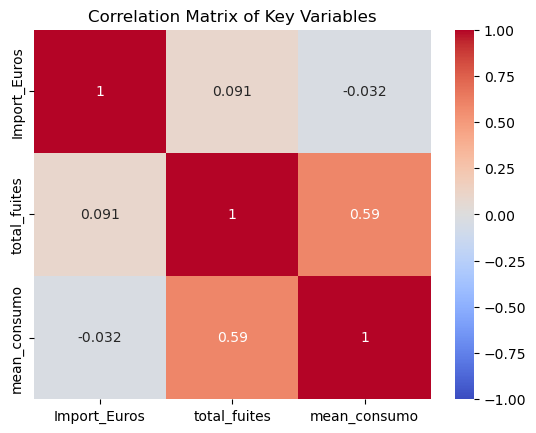

In [12]:
#COMPUTE CORRELATIONS

# Select relevant numeric columns
corr_vars = ['Import_Euros', 'total_fuites', 'mean_consumo']

corr_matrix = df_vulnerability[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Key Variables")
plt.show()

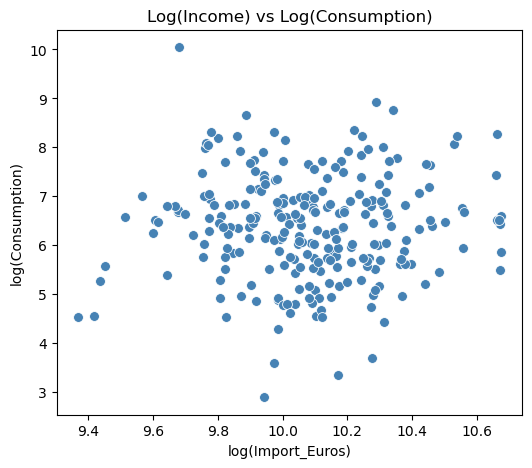

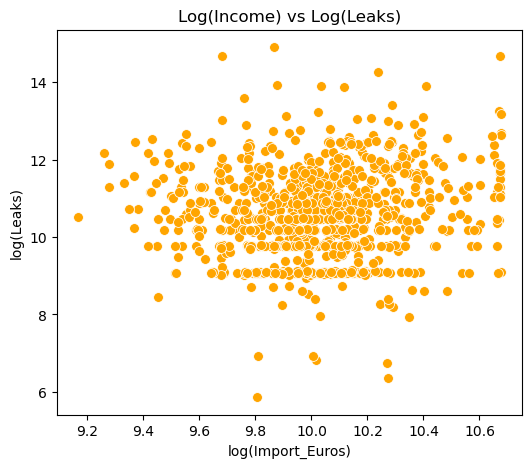

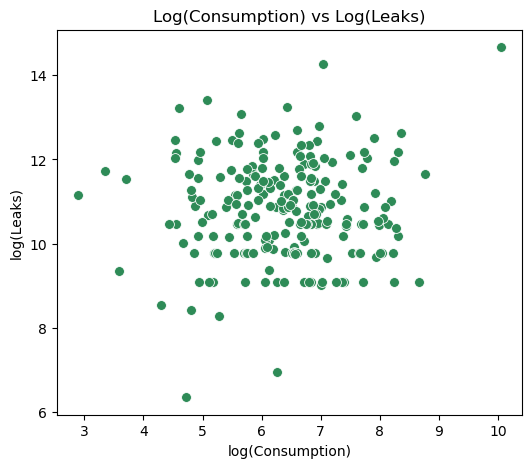

In [13]:
#SCATTER PLOTS  (log transform)

# --- Create log-transformed variables ---
df_vulnerability['log_consumo'] = np.log1p(df_vulnerability['mean_consumo'])
df_vulnerability['log_fuites'] = np.log1p(df_vulnerability['total_fuites'])
df_vulnerability['log_income'] = np.log1p(df_vulnerability['Import_Euros'])

# --- 1. Log(Income) vs Log(Consumption) ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='log_income', y='log_consumo', data=df_vulnerability, color='steelblue', edgecolor='white', s=50)
plt.title("Log(Income) vs Log(Consumption)")
plt.xlabel("log(Import_Euros)")
plt.ylabel("log(Consumption)")
plt.show()

# --- 2. Log(Income) vs Log(Leaks) ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='log_income', y='log_fuites', data=df_vulnerability, color='orange', edgecolor='white', s=50)
plt.title("Log(Income) vs Log(Leaks)")
plt.xlabel("log(Import_Euros)")
plt.ylabel("log(Leaks)")
plt.show()

# --- 3. Log(Consumption) vs Log(Leaks) ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='log_consumo', y='log_fuites', data=df_vulnerability, color='seagreen', edgecolor='white', s=50)
plt.title("Log(Consumption) vs Log(Leaks)")
plt.xlabel("log(Consumption)")
plt.ylabel("log(Leaks)")
plt.show()

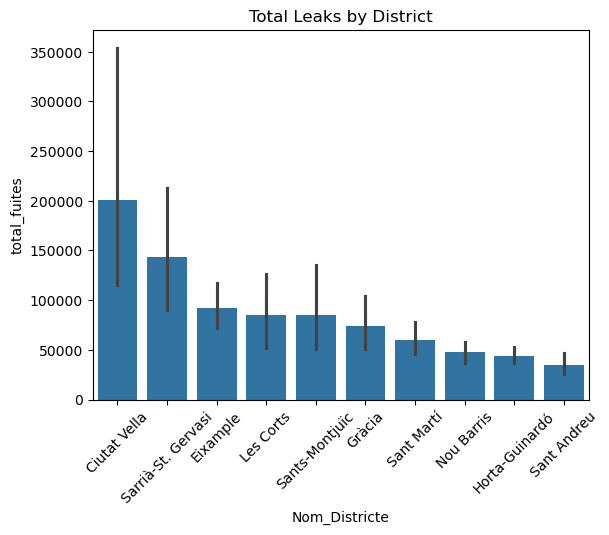

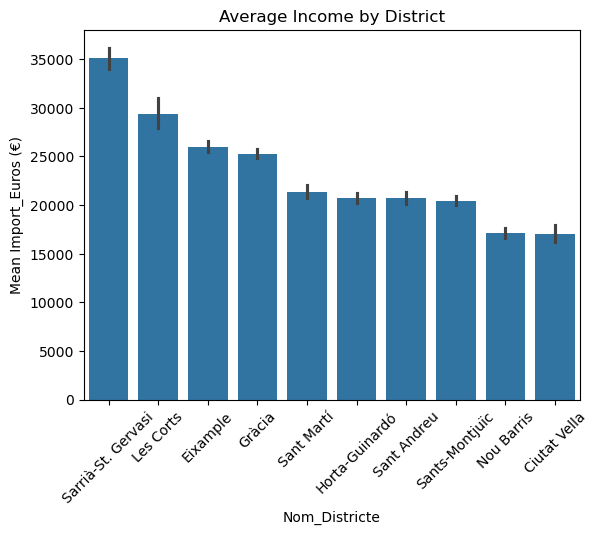

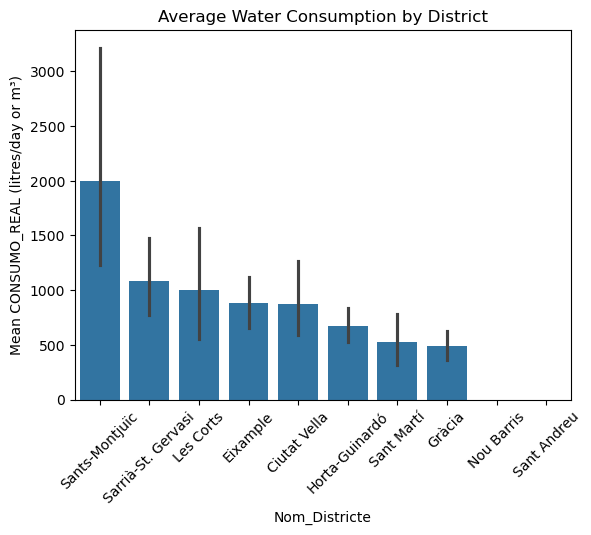

In [18]:
# SPATIAL ANALYSIS
#Average leaks per district
sns.barplot(
    x='Nom_Districte',
    y='total_fuites',
    data=df_vulnerability,
    order=df_vulnerability.groupby('Nom_Districte')['total_fuites'].mean().sort_values(ascending=False).index)
plt.xticks(rotation=45)
plt.title("Total Leaks by District")
plt.show()

# Average income per district
sns.barplot(
    x='Nom_Districte',
    y='Import_Euros',
    data=df_vulnerability,
    order=df_vulnerability.groupby('Nom_Districte')['Import_Euros']
         .mean().sort_values(ascending=False).index
)
plt.xticks(rotation=45)
plt.title("Average Income by District")
plt.ylabel("Mean Import_Euros (€)")
plt.show()

# Average consumption per district
sns.barplot(
    x='Nom_Districte',
    y='mean_consumo',
    data=df_vulnerability,
    order=df_vulnerability.groupby('Nom_Districte')['mean_consumo']
         .mean().sort_values(ascending=False).index
)
plt.xticks(rotation=45)
plt.title("Average Water Consumption by District")
plt.ylabel("Mean CONSUMO_REAL (litres/day or m³)")
plt.show()